In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import scipy.stats as stats
import matplotlib
matplotlib.rcParams['font.family'] ='Malgun Gothic'
matplotlib.rcParams['axes.unicode_minus'] =False

In [2]:
df = pd.read_csv('C:/Users/user/github/Data/energy/train.csv', encoding='cp949')

In [3]:
eda_df = df.copy()

In [4]:
eda_df['month'] = 0
eda_df['hour'] = 0
eda_df['year'] = 0
eda_df['day'] = 0
eda_df['요일'] = 0

In [11]:
eda_df.date_time = pd.to_datetime(eda_df.date_time)

In [15]:
days = {0: '월요일', 1: '화요일', 2: '수요일', 3: '목요일', 4: '금요일', 5: '토요일', 6: '일요일'}

In [16]:
eda_df['month'] = eda_df.date_time.dt.month
eda_df['hour'] = eda_df.date_time.dt.hour
eda_df['year'] = eda_df.date_time.dt.year
eda_df['day'] = eda_df.date_time.dt.day
eda_df['요일'] = eda_df['date_time'].dt.weekday.map(days)

In [17]:
input = eda_df.drop(['기온(°C)','풍속(m/s)','습도(%)','강수량(mm)','일조(hr)','비전기냉방설비운영','태양광보유','month'], axis=1)

In [18]:
mean = pd.DataFrame(input.groupby(['num','요일','hour']).mean()['전력사용량(kWh)'])

In [19]:
std = pd.DataFrame(input.groupby(['num','요일','hour']).std()['전력사용량(kWh)'])

In [20]:
total_df = pd.merge(mean, std, how='inner', left_on = ['num','요일','hour'], right_on=['num','요일','hour'])

In [22]:
total_df.reset_index(inplace=True)

In [23]:
total_df.columns = ['num' ,'요일', 'hour', 'mean', 'std']

In [24]:
class HourlyDataUpdater:
    def __init__(self, hourly_means, hourly_std_devs, alpha=0.1):
        self.hourly_means = hourly_means
        self.hourly_std_devs = hourly_std_devs
        self.alpha = alpha

    def update(self, hour, new_data):
        old_mean = self.hourly_means[hour]
        old_std_dev = self.hourly_std_devs[hour]

        # 평균 업데이트
        new_mean = old_mean * (1 - self.alpha) + new_data * self.alpha

        # 표준편차 업데이트
        new_std_dev = np.sqrt((1 - self.alpha) * (old_std_dev ** 2) + self.alpha * ((new_data - old_mean) ** 2))

        # 값 업데이트
        self.hourly_means[hour] = new_mean
        self.hourly_std_devs[hour] = new_std_dev

        return new_mean

    def predict(self, hour, new_data):
        updated_mean = self.update(hour, new_data)
        return stats.norm(updated_mean, self.hourly_std_devs[hour]).pdf(new_data)

In [28]:
def get_weekday_indices(index):
    datetime_index = pd.DatetimeIndex(index)
    weekday_indices = datetime_index[datetime_index.weekday < 5]
    return weekday_indices

In [39]:
df_1 = df[df['num']==1]

In [41]:
df_1.date_time = pd.to_datetime(df_1.date_time)

In [42]:
df_1 = df_1.set_index(['date_time'])

In [43]:
weekday = get_weekday_indices(df_1.index)

In [44]:
weekday

DatetimeIndex(['2020-06-01 00:00:00', '2020-06-01 01:00:00',
               '2020-06-01 02:00:00', '2020-06-01 03:00:00',
               '2020-06-01 04:00:00', '2020-06-01 05:00:00',
               '2020-06-01 06:00:00', '2020-06-01 07:00:00',
               '2020-06-01 08:00:00', '2020-06-01 09:00:00',
               ...
               '2020-08-24 14:00:00', '2020-08-24 15:00:00',
               '2020-08-24 16:00:00', '2020-08-24 17:00:00',
               '2020-08-24 18:00:00', '2020-08-24 19:00:00',
               '2020-08-24 20:00:00', '2020-08-24 21:00:00',
               '2020-08-24 22:00:00', '2020-08-24 23:00:00'],
              dtype='datetime64[ns]', name='date_time', length=1464, freq=None)

In [45]:
input_1 = df_1.loc[weekday]

In [57]:
mean = eda_df[(eda_df['태양광보유'] == 0) & (eda_df['num']==1)][:1440].groupby(['hour']).mean()['전력사용량(kWh)']
std = eda_df[(eda_df['태양광보유'] == 0) & (eda_df['num']==1)][:1440].groupby(['hour']).std()['전력사용량(kWh)']

In [58]:
mean

hour
0     8503.2504
1     8476.0776
2     8469.9216
3     8454.2508
4     8441.1828
5     8417.1096
6     8410.7592
7     8439.4440
8     8454.1860
9     8495.6148
10    8514.0180
11    8519.2344
12    8516.1996
13    8533.8036
14    8557.2504
15    8564.9616
16    8566.3332
17    8558.3088
18    8542.1844
19    8544.9492
20    8535.9420
21    8538.3612
22    8536.7412
23    8516.8692
Name: 전력사용량(kWh), dtype: float64

In [61]:
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

In [85]:
hourly_means = mean 
hourly_std_devs = std
total_means = []
pred_error_mse = []
pred_error_mae = []

for i in range(30):
    new_data = input_1.iloc[24*i : 24*(i+1), 1]

    updater = HourlyDataUpdater(hourly_means, hourly_std_devs, alpha=0.1)

    updated_means = []
    for hour, data in enumerate(new_data):
        updated_mean = updater.update(hour, data)
        updated_means.append(updated_mean)
    
    pred_error_mse.append(mean_squared_error(new_data, updated_means))
    pred_error_mae.append(mean_absolute_error(new_data, updated_means))
    
    total_means.append(updated_means)

In [86]:
mean_absolute_error(new_data, updated_means)

29.295376384653007

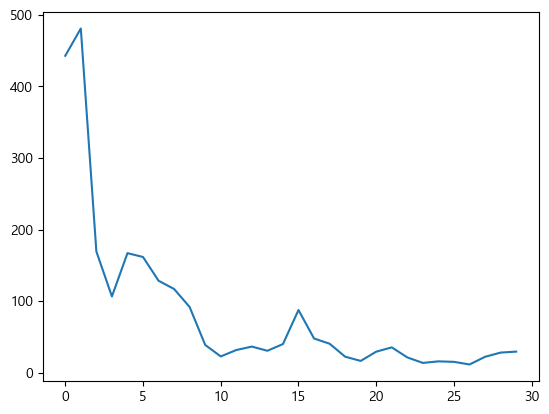

In [87]:
plt.plot(pred_error_mae)